# 使用ECC（Enhanced Correlation Coefficient）来校正图像

In [1]:
import numpy as np
import cv2
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
im1 =  cv2.imread("../datas/image1.jpg");
im2 =  cv2.imread("../datas/image2.jpg");
 
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

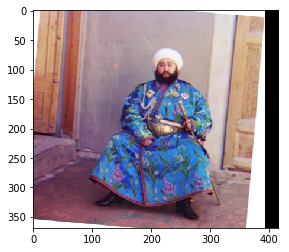

In [6]:
# Find size of image1
sz = im1.shape
 
# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION
 
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 5000;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
 
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
plt.imshow(cv2.cvtColor(im2_aligned,cv2.COLOR_BGR2RGB))

In [10]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

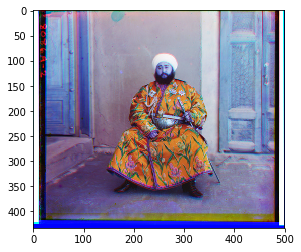

In [11]:
im =  cv2.imread("../datas/emir.jpg", cv2.IMREAD_GRAYSCALE);
 
# Find the width and height of the color image
sz = im.shape
   
height = int(sz[0] / 3);
width = sz[1]
 
# Extract the three channels from the gray scale image
# and merge the three channels into one color image
im_color = np.zeros((height,width,3), dtype=np.uint8 )
for i in range(0,3) :
    im_color[:,:,i] = im[ i * height:(i+1) * height,:]
# Allocate space for aligned image
im_aligned = np.zeros((height,width,3), dtype=np.uint8 )
 
# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[:,:,2] = im_color[:,:,2]
 
# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
 
# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
 
# Warp the blue and green channels to the red channel
for i in range(0,2) :
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im_color[:,:,2]), get_gradient(im_color[:,:,i]),warp_matrix, warp_mode, criteria)
 
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use Perspective warp when the transformation is a Homography
        im_aligned[:,:,i] = cv2.warpPerspective (im_color[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
            # Use Affine warp when the transformation is not a Homography
        im_aligned[:,:,i] = cv2.warpAffine(im_color[:,:,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
plt.imshow(im_aligned)

参考：

[1]. https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/